In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [4]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision as tv
import numpy as np

In [5]:
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage()
print(t.__version__)

1.7.0


In [6]:
import time

In [7]:
# 数据预处理，相当于提前定义了怎么处理数据：
# 因为读入的数据为numpy格式，所以我们要先将其转换为tensor格式，
# 然后对其进行归一化，有三个通道需要归一化，而第一个为均值，第二个为标准差
transform = transforms.Compose([
    transforms.ToTensor(), # 转为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 训练集
trainset = tv.datasets.CIFAR10(
    root='/kaggle/input/cifar10-python',
    train=True,
    download=False,
    transform=transform
)

# 迭代器
trainloader = t.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

# 测试集
testset = tv.datasets.CIFAR10(
    root='/kaggle/input/cifar10-python',
    train=False,
    download=False,
    transform=transform
)

# 迭代器
testloader = t.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

ship


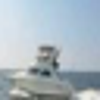

In [8]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

In [9]:
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

ship       frog       dog       deer


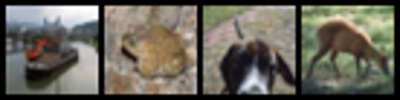

In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('       '.join(classes[labels]))
show(tv.utils.make_grid((images + 1) / 2)).resize((400, 100))

In [11]:
# AlexNet
NUM_CLASSES = 10

class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),   # (32 + 1*2 - 3) / 2 + 1 = 16
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),                        # (16 + 0 * 2 - 2) / 2  + 1 = 8
            nn.Conv2d(64, 192, kernel_size=3, padding=1),    # (8 + 1 * 2 - 3) / 1 + 1 = 8
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),    # (8 + 0 * 2 - 2) / 2 + 1 = 4
            nn.Conv2d(192, 384, kernel_size=3, padding=1),   # (4 + 1 * 2 - 3) / 1 + 1 = 4
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),   # (4 + 1 * 2 - 3) / 1 + 1 = 4
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),   # (4 + 1 * 2 - 3) / 1 + 1 = 4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),    # (4 + 0 * 2 - 2) / 2 + 1 = 2
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)   # 变换Tensor形状
        x = self.classifier(x)
        return x

alexnet = AlexNet()
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [12]:
for name, param in alexnet.named_parameters():
    print(name, param.size())

features.0.weight torch.Size([64, 3, 3, 3])
features.0.bias torch.Size([64])
features.3.weight torch.Size([192, 64, 3, 3])
features.3.bias torch.Size([192])
features.6.weight torch.Size([384, 192, 3, 3])
features.6.bias torch.Size([384])
features.8.weight torch.Size([256, 384, 3, 3])
features.8.bias torch.Size([256])
features.10.weight torch.Size([256, 256, 3, 3])
features.10.bias torch.Size([256])
classifier.1.weight torch.Size([4096, 1024])
classifier.1.bias torch.Size([4096])
classifier.4.weight torch.Size([4096, 4096])
classifier.4.bias torch.Size([4096])
classifier.6.weight torch.Size([10, 4096])
classifier.6.bias torch.Size([10])


In [13]:
# 定义优化器和损失函数
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [14]:
# move the input and model to GPU for speed if available
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

In [15]:
print(device)

cuda:0


In [16]:
alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [17]:
# 训练网络

for epoch in range(7):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = alexnet(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet')

[1,  2000] loss: 2.303
Time: 28.57809829711914
[1,  4000] loss: 2.284
Time: 56.35834264755249
[1,  6000] loss: 2.083
Time: 82.71125888824463
[1,  8000] loss: 1.925
Time: 109.84061908721924
[1, 10000] loss: 1.794
Time: 136.55797386169434
[1, 12000] loss: 1.721
Time: 163.51585030555725
[2,  2000] loss: 1.631
Time: 27.417130708694458
[2,  4000] loss: 1.565
Time: 54.55638861656189
[2,  6000] loss: 1.506
Time: 81.2222306728363
[2,  8000] loss: 1.412
Time: 108.37295246124268
[2, 10000] loss: 1.343
Time: 135.59888696670532
[2, 12000] loss: 1.292
Time: 162.48995542526245
[3,  2000] loss: 1.208
Time: 27.00969409942627
[3,  4000] loss: 1.173
Time: 54.1054584980011
[3,  6000] loss: 1.138
Time: 80.87949848175049
[3,  8000] loss: 1.119
Time: 107.46526145935059
[3, 10000] loss: 1.104
Time: 134.41111278533936
[3, 12000] loss: 1.043
Time: 161.520192861557
[4,  2000] loss: 0.968
Time: 27.116586208343506
[4,  4000] loss: 0.971
Time: 54.653820514678955
[4,  6000] loss: 0.926
Time: 81.43610692024231
[4,  

In [20]:
#Testing Accuracy
correct = 0
total = 0
with t.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predicted = t.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 84.77 %


In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with t.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predicted = t.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 90 %
Accuracy of   car : 96 %
Accuracy of  bird : 79 %
Accuracy of   cat : 77 %
Accuracy of  deer : 82 %
Accuracy of   dog : 74 %
Accuracy of  frog : 82 %
Accuracy of horse : 87 %
Accuracy of  ship : 84 %
Accuracy of truck : 92 %


In [24]:
#Verifying average accuracy of the network
avg = 0
for i in range(10):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/10
print('Average accuracy = ', avg)

Average accuracy =  84.898
